In [62]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
import lightgbm as lgb

In [15]:
#upload files

file_folder = '/Users/rosleeb/disaster_tweets'
train = pd.read_csv(f'{file_folder}/train.csv')
test = pd.read_csv(f'{file_folder}/test.csv')

In [16]:
#function to convert test to lowercase
def lowercase(tweet):
    lower_tweet = tweet.lower()
    return lower_tweet

#untokenize words
def untokenize(words):
    text = ' '.join(words)
    step1 = text.replace("`` ", '"').replace(" ''", '"').replace('. . .', '...')
    step2 = step1.replace(" ( ", " (").replace(" ) ", ") ")
    step3 = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", step2)
    step4 = re.sub(r' ([.,:;?!%]+)$', r"\1", step3)
    step5 = step4.replace(" '", "'").replace(" n't", "n't").replace(
        "can not", "cannot")
    step6 = step5.replace(" ` ", " '")
    return step6.strip()

#tokenizes text and removes stop words
def filter_sentence(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_sentence = [w for w in tokens if not w in stop_words]
    return filtered_sentence

In [17]:
target = train['target']
train.drop(['target'], axis = 1)

,id,keyword,location,text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...


In [18]:
target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [19]:
lowercases = []

for i in range(train['text'].count()):
    lowered = lowercase(train['text'][i])
    lowercases.append(lowered)

low_tweets = pd.DataFrame(lowercases, columns = ['lowered_text'])

#low_tweets.head()

train = train.join(low_tweets)

lowercases = []


for i in range(test['text'].count()):
    lowered = lowercase(test['text'][i])
    lowercases.append(lowered)

low_tweets = pd.DataFrame(lowercases, columns = ['lowered_text'])

#low_tweets.head()

test = test.join(low_tweets)


In [20]:
train.drop(['target'], axis = 1)

,id,keyword,location,text,lowered_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this #earthquake m...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby #alaska as ...
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,@aria_ahrary @thetawniest the out of control w...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,police investigating after an e-bike collided ...


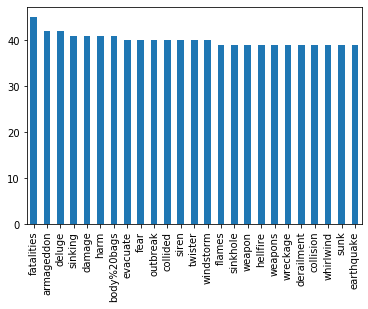

In [21]:
pd.value_counts(train['keyword'])[0:25].plot(kind='bar')

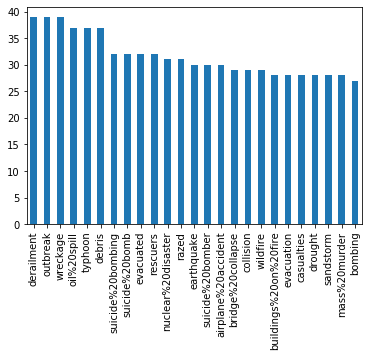

In [22]:
train_fakes = train.loc[train['target'] == 1]

pd.value_counts(train_fakes['keyword'])[0:25].plot(kind='bar')

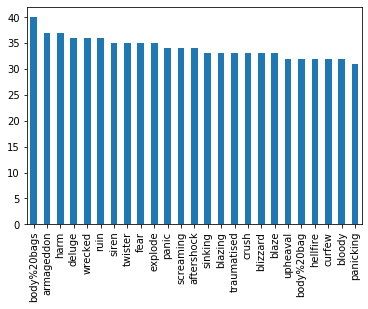

In [23]:
train_real = train.loc[train['target'] == 0]

pd.value_counts(train_real['keyword'])[0:25].plot(kind='bar')

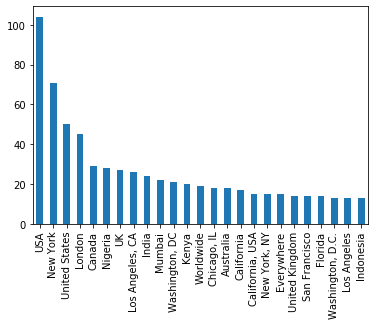

In [24]:
pd.value_counts(train['location'])[0:25].plot(kind='bar')

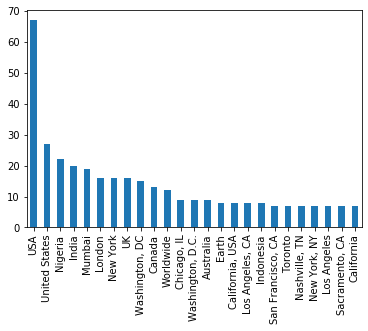

In [25]:
loc_fakes = train.loc[train['target'] == 1]

pd.value_counts(loc_fakes['location'])[0:25].plot(kind='bar')

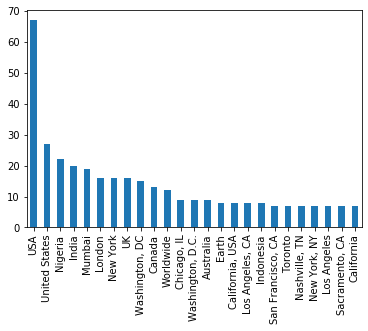

In [26]:
loc_real = train.loc[train['target'] == 1]

pd.value_counts(loc_real['location'])[0:25].plot(kind='bar')

In [29]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
X_train_embeddings = embed(train['lowered_text'].values)
X_test_embeddings = embed(test['lowered_text'].values)

In [42]:
n_estimators = 1500
n_jobs = -1
verbose = 50
early_stopping_rounds = 200
learning_rate = 0.05


lgb_model = lgb.LGBMClassifier(learning_rate=learning_rate, n_estimators=n_estimators, n_jobs = n_jobs, eval_metric = 'f1_score')

lgb_model.fit(X_train_embeddings[:5000,:], target.values[:5000],
             eval_set=[(X_train_embeddings[:5000,:], target.values[:5000]),
                       (X_train_embeddings[5000:,:], target.values[5000:])],
             verbose=verbose, early_stopping_rounds=early_stopping_rounds,
            )

lgb_model.fit(X_train_embeddings[:5000,:], target.values[:5000])
Y_pred = lgb_model.predict(X_train_embeddings[5000:])

print(metrics.classification_report(target[5000:], Y_pred, digits=3),) 
print(metrics.confusion_matrix(target[5000:], Y_pred))

Training until validation scores don't improve for 200 rounds
[50]	valid_0's binary_logloss: 0.318431	valid_1's binary_logloss: 0.454364
[100]	valid_0's binary_logloss: 0.200564	valid_1's binary_logloss: 0.427029
[150]	valid_0's binary_logloss: 0.134168	valid_1's binary_logloss: 0.418406
[200]	valid_0's binary_logloss: 0.0932301	valid_1's binary_logloss: 0.420903
[250]	valid_0's binary_logloss: 0.0664983	valid_1's binary_logloss: 0.424996
[300]	valid_0's binary_logloss: 0.0485212	valid_1's binary_logloss: 0.432892
[350]	valid_0's binary_logloss: 0.036236	valid_1's binary_logloss: 0.442022
Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.120022	valid_1's binary_logloss: 0.417358
              precision    recall  f1-score   support

           0      0.805     0.881     0.841      1436
           1      0.836     0.740     0.785      1177

    accuracy                          0.817      2613
   macro avg      0.821     0.810     0.813      2613
weighted avg      0.8

In [44]:
reg_model = LogisticRegression()
reg_model.fit(X_train_embeddings[:5000,:], target.values[:5000])
y_pred_reg = reg_model.predict(X_train_embeddings[5000:])
f1_score(target[5000:], y_pred_reg, average='weighted')

print(metrics.classification_report(target[5000:], y_pred_reg, digits=3),) 
print(metrics.confusion_matrix(target[5000:], y_pred_reg))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0      0.815     0.873     0.843      1436
           1      0.830     0.758     0.792      1177

    accuracy                          0.821      2613
   macro avg      0.822     0.815     0.817      2613
weighted avg      0.821     0.821     0.820      2613

[[1253  183]
 [ 285  892]]


In [63]:
lgb_model.fit(X_train_embeddings, target.values)
y_pred = lgb_model.predict(X_test_embeddings)

output = pd.DataFrame({'id': test['id'],
                       'target': y_pred})
output.to_csv('submission.csv', index=False)